In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import os
from ast import literal_eval
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import matplotlib.ticker as ticker
import squarify

#Scikit - surprise library를 사용하려면 movie, rating, user 정보가 있어야 한다.

In [2]:
%cd "C:/Users/ksmin/ML_termProject/dataset/archive/"

C:\Users\ksmin\ML_termProject\dataset\archive


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

movies = pd.read_csv("movies_metadata.csv")
credits = pd.read_csv("credits.csv")
keywords = pd.read_csv("keywords.csv")
ratings = pd.read_csv("ratings.csv")

C:\Users\ksmin\AppData\Local\Temp\ipykernel_11212\616750264.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv")


## Load Data
- analyse the movie meta dataset
- Convert list of dictionary with Python list type
- Using pd_datetime, select year

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
movies.shape

(45466, 24)

In [5]:
movies.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [10]:
for col in movies.columns:
    print(f"{col} : \n {movies[col].unique()}\n")

adult : 
 ['False' 'True' ' - Written by Ørnås'
 ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.'
 ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.']

belongs_to_collection : 
 ["{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}"
 nan
 "{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}"
 ...
 "{'id': 148603, 'name': 'Ducobu Collection', 'poster_path': '/rd7AWZUy2QFPIblNWToVmdfXQcA.jpg', 'backdrop_path': '/7mzKmoIrvGapvsSbAVlX4HtCnFj.jpg'}"
 "{'id': 152918, 'name': 'Mister Blot Collection', 'poster_path': '/44PYEwwjGts8pAob59RHd6zlkKc.jpg', 'backdrop_path': '/5uoPsNiFpUYNamSGqE8okN27VRK.jpg'}"
 "{'id': 200641, 'name': 'Red Lotus Collection', 'p

In [14]:
duplicated_ids = movies['id'].duplicated().sum()

print(f"Number of duplicate ids: {duplicated_ids}")

Number of duplicate ids: 30


In [16]:
movies = movies.drop_duplicates(subset='id', keep = 'first')

#index setting : 기존 삭제되었던 index 제거
movies.reset_index(drop=True, inplace=True)

movies.shape

(45436, 24)

In [17]:
"""
genre, production_company, production_country, spoken_language are stored as string representation of list of dictionary
So these will be transformed to actual Python lists and replaces missing values in the columns with empty lists.
"""

movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies['production_companies']= movies['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies['production_countries'] = movies['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies['spoken_languages'] = movies['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [18]:
movies['genres'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

In [19]:
#Select Year
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

movies['year'].head()

0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object

In [20]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995


## Feature Engineering

Weighted ranking is often used in movie ranking systems to rank movies based on both their average rating and the number of votes they have received. The purpose is to give a fairer rank to movies by considering both the rating quality (R) and the popularity (v) of the movie, preventing less-voted but highly-rated movies from unfairly dominating the list.

The Formula of Weighted Rank(WR):

WR=(v/v+m)×R+(m/v+m)×C
 
Where:

( R ) = average rating of the movie

( v ) = number of votes for the movie

( m ) = minimum votes required to be listed in the Top 250

( C ) = the mean vote across the whole dataset

In [21]:
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')

vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

In [22]:
C = vote_averages.mean()

m = vote_counts.quantile(0.90)  # only movies in the top 10% (with the highest number of votes) will be considered.

print('The Mean value of the voting averages:',C)

print('The minimum vote count for a movie to consider: ',m)

The Mean value of the voting averages: 5.24503631961259
The minimum vote count for a movie to consider:  160.0


### create a new dataframe containing only the movies that meet the following conditions:
- The movie’s vote_count must be greater than or equal to m (the 90th percentile of votes).
- The movie’s vote_count and vote_average must be non-null (i.e., they exist).

In [23]:
df = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())][['id','title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

df.head()

,id,title,year,vote_count,vote_average,popularity,genres
0,862,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]"
1,8844,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]"
4,11862,Father of the Bride Part II,1995,173.0,5.7,8.387519,[Comedy]
5,949,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]"
8,9091,Sudden Death,1995,174.0,5.5,5.23158,"[Action, Adventure, Thriller]"


In [24]:
df['vote_count'] = df['vote_count'].astype('int')

df['vote_average'] = df['vote_average'].astype('int')

print(df.shape)

(4551, 7)


In [25]:
df['w_ratings'] = (df['vote_count'] / (df['vote_count'] + m)) * df['vote_average'] + (m / (df['vote_count'] + m)) * C

df

,id,title,year,vote_count,vote_average,popularity,genres,w_ratings
0,862,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.949633
1,8844,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.953053
4,11862,Father of the Bride Part II,1995,173,5,8.387519,[Comedy],5.117735
5,949,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.862759
8,9091,Sudden Death,1995,174,5,5.23158,"[Action, Adventure, Thriller]",5.117383
...,...,...,...,...,...,...,...,...
45145,339692,Shot Caller,2017,324,6,15.786854,"[Drama, Crime, Thriller]",5.750425
45148,375798,Brice 3,2016,160,4,7.276407,[Comedy],4.622518
45175,417870,Girls Trip,2017,393,7,37.964872,[Comedy],6.492235
45229,417320,Descendants 2,2017,171,7,15.842073,"[TV Movie, Family, Action, Comedy, Music, Adve...",6.151679


In [26]:
unique_titles_count = df['title'].nunique()

total_titles_count = df['title'].count()

print("\nUnique titles:", unique_titles_count)

print("Total titles:", total_titles_count)

print("Number of duplicate titles:", total_titles_count - unique_titles_count)


Unique titles: 4460
Total titles: 4551
Number of duplicate titles: 91


In [27]:
duplicates = df[df.duplicated(subset=['title'], keep=False)]



duplicate_titles_df = duplicates.sort_values('title') # create a new DataFrame containing all rows with duplicate titles

print("DataFrame containing duplicate titles:\n")

duplicate_titles_df

DataFrame containing duplicate titles:



,id,title,year,vote_count,vote_average,popularity,genres,w_ratings
1299,377,A Nightmare on Elm Street,1984,1212,7,13.694713,[Horror],6.795340
15179,23437,A Nightmare on Elm Street,2010,771,5,10.40191,"[Horror, Mystery, Thriller]",5.042112
14887,12155,Alice in Wonderland,2010,4773,6,17.285093,"[Family, Fantasy, Adventure]",5.975513
1003,12092,Alice in Wonderland,1951,1557,7,16.488937,"[Animation, Adventure, Family, Fantasy]",6.836462
25702,196867,Annie,2014,472,6,13.275529,"[Comedy, Drama, Family]",5.808870
...,...,...,...,...,...,...,...,...
4623,16307,The Wicker Man,1973,313,7,7.206941,"[Horror, Music, Mystery, Thriller]",6.406355
2799,861,Total Recall,1990,1745,7,12.954444,"[Action, Adventure, Science Fiction]",6.852601
19210,64635,Total Recall,2012,2540,5,16.42635,"[Action, Science Fiction, Adventure, Thriller]",5.014521
3372,17529,True Grit,1969,205,7,12.497833,[Western],6.230701


In [28]:
df_exploded = df.explode('genres')

df_exploded = df_exploded.rename(columns={'genres': 'genre'})

df_exploded

,id,title,year,vote_count,vote_average,popularity,genre,w_ratings
0,862,Toy Story,1995,5415,7,21.946943,Animation,6.949633
0,862,Toy Story,1995,5415,7,21.946943,Comedy,6.949633
0,862,Toy Story,1995,5415,7,21.946943,Family,6.949633
1,8844,Jumanji,1995,2413,6,17.015539,Adventure,5.953053
1,8844,Jumanji,1995,2413,6,17.015539,Fantasy,5.953053
...,...,...,...,...,...,...,...,...
45229,417320,Descendants 2,2017,171,7,15.842073,Action,6.151679
45229,417320,Descendants 2,2017,171,7,15.842073,Comedy,6.151679
45229,417320,Descendants 2,2017,171,7,15.842073,Music,6.151679
45229,417320,Descendants 2,2017,171,7,15.842073,Adventure,6.151679


In [29]:
top250 = df_exploded.sort_values('w_ratings', ascending=False).drop_duplicates('title').head(250)

top250

,id,title,year,vote_count,vote_average,popularity,genre,w_ratings
10306,19404,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,Drama,8.268217
15474,27205,Inception,2010,14075,8,29.108149,Adventure,7.969034
12477,155,The Dark Knight,2008,12269,8,123.167259,Action,7.964535
22865,157336,Interstellar,2014,11187,8,32.213481,Adventure,7.961153
2842,550,Fight Club,1999,9678,8,63.869599,Drama,7.955195
...,...,...,...,...,...,...,...,...
11004,350,The Devil Wears Prada,2006,3198,7,13.102384,Drama,6.916381
21592,146233,Prisoners,2013,3183,7,11.96262,Drama,6.916005
13183,13223,Gran Torino,2008,3181,7,14.794228,Drama,6.915955
21264,138843,The Conjuring,2013,3169,7,14.90169,Horror,6.915652


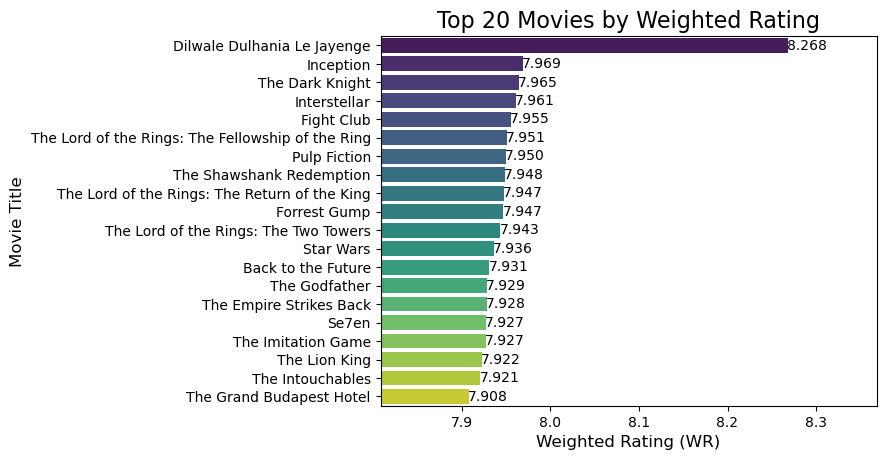

In [30]:
top20 = df_exploded.sort_values('w_ratings', ascending=False).drop_duplicates('title').head(20)

sns.barplot(x='w_ratings', y='title', data=top20, palette='viridis')
plt.title('Top 20 Movies by Weighted Rating',fontsize=16)
plt.xlabel('Weighted Rating (WR)', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)

# Get the minimum and maximum values in 'w_ratings' to set appropriate xlim
min_wr = top20['w_ratings'].min()
max_wr = top20['w_ratings'].max()

# Set xlim based on the actual data, but zoom in slightly to highlight differences
plt.xlim(min_wr - 0.1, max_wr + 0.1)

# Add the exact WR value on the bars for higher precision
for index, value in enumerate(top20['w_ratings']):
    plt.text(value - 0.001, index, f'{value:.3f}', color='black', va="center")

# Format the x-axis ticks to show only one decimal place
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.show()    

In [31]:
# Count the number of movies per genre in the top 250 dataframe
genre_count = top250['genre'].value_counts().reset_index()
genre_count.columns = ['genre', 'count']  # Rename columns for clarity
genre_count

,genre,count
0,Drama,60
1,Adventure,30
2,Thriller,25
3,Action,20
4,Science Fiction,16
5,Family,16
6,Animation,14
7,Comedy,14
8,Romance,13
9,Fantasy,12


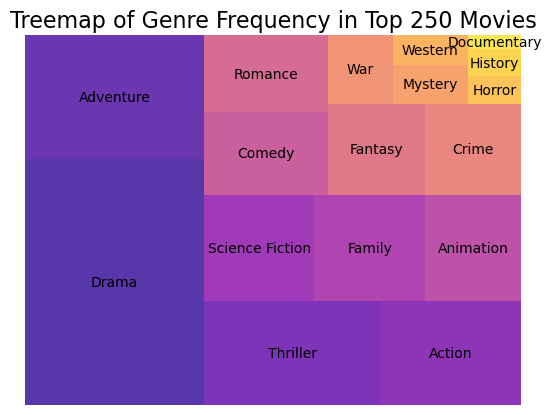

In [32]:
# Normalize the genre counts for better visualization
sizes = genre_count['count']

# Create a treemap
squarify.plot(sizes=sizes, label=genre_count['genre'], alpha=0.8, color=sns.color_palette('plasma', len(genre_count)))
plt.title('Treemap of Genre Frequency in Top 250 Movies', fontsize=16)
plt.axis('off')
plt.show()

In [33]:
# Count the number of movies per genre in the top 20 DataFrame
genre_count2 = top20['genre'].value_counts().reset_index()
genre_count2.columns = ['genre', 'count']
genre_count2

,genre,count
0,Adventure,5
1,Drama,4
2,Comedy,3
3,Thriller,2
4,Crime,2
5,Action,1
6,Fantasy,1
7,Science Fiction,1
8,Animation,1


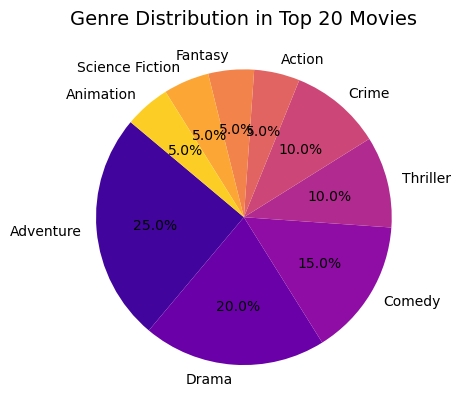

In [34]:
plt.pie(genre_count2['count'], labels=genre_count2['genre'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('plasma', len(genre_count2)))
plt.title('Genre Distribution in Top 20 Movies', fontsize=14)
plt.gca().set_aspect('equal')  # Equal aspect ratio to ensure the donut is circular
plt.show()

In [35]:
def get_top_movies_by_genre(genre, df):
    """
    Returns a DataFrame with the top 10 movies for a specific genre from the provided DataFrame.
    Parameters:
    genre (str): The genre for which to retrieve the top movies.
    df (DataFrame): The DataFrame containing the top movies.
    Returns:
    DataFrame: A filtered DataFrame with the top 10 movies for the given genre, including title, year, popularity, genre, and w_ratings.
    """
    
    # Filter the DataFrame for the specified genre
    genre_movies = df[df['genre'].str.contains(genre, case=False, na=False)]

    # Sort the filtered DataFrame by weighted ratings in descending order
    top_movies = genre_movies.sort_values(by='w_ratings', ascending=False).head(10)

    # Return the filtered DataFrame (title, year, popularity, genre, and w_ratings for better visualization)
    return top_movies[['title', 'year', 'popularity', 'w_ratings']].drop_duplicates('title')

In [36]:
get_top_movies_by_genre('Action', df_exploded)

,title,year,popularity,w_ratings
15474,Inception,2010,29.108149,7.969034
12477,The Dark Knight,2008,123.167259,7.964535
4862,The Lord of the Rings: The Fellowship of the Ring,2001,32.070725,7.951304
6999,The Lord of the Rings: The Return of the King,2003,29.324358,7.947437
5813,The Lord of the Rings: The Two Towers,2002,29.423537,7.943495
256,Star Wars,1977,42.149697,7.936467
1154,The Empire Strikes Back,1980,19.470959,7.928419
4134,Scarface,1983,11.299673,7.861255
9427,Oldboy,2003,10.616859,7.795929
1909,Seven Samurai,1954,15.01777,7.580994
